## Walk through postage stamp creation in `ts_wep`

In [26]:
import os
import numpy as np
import pandas as pd
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
%matplotlib inline

Load an postISR exposure of the intra defocal image using the Butler.

In [2]:
repo_dir = '/astro/users/brycek/epyc/users/brycek/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/test_output/donutDetect_5/input/rerun/run1'
butler = dafPersist.Butler(repo_dir)

In [3]:
raft = 'R22'
detector = 'S00'
detector_string = 'R:2,2 S:0,0'
abbrev_detector = '%s_%s' % (raft, detector)
data_id = {'visit': 9006002, 'raftName': raft, 'detectorName': detector}

In [4]:
postIsrButlerExp = butler.get('postISRCCD', **data_id)

Load the `ts_wep` tools we will need

In [5]:
from lsst.ts.wep.WepController import WepController
from lsst.ts.wep.Utility import CamType, FilterType

In [6]:
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory

In [7]:
wep_calc = WEPCalculationFactory.getCalculator(CamType.ComCam, repo_dir)

In [8]:
wep_cntl = wep_calc.wepCntlr

In [9]:
wep_cntl.setPostIsrCcdInputs(repo_dir)

In [10]:
isrImgMap = wep_cntl.getPostIsrImgMapByPistonDefocal(['R:2,2 S:0,0', 'R:2,2 S:0,1', 'R:2,2 S:0,2'], [9006001, 9006002])

In [11]:
isrImgMap

{'R:2,2 S:0,0': <lsst.ts.wep.DefocalImage.DefocalImage at 0x7f222057a750>,
 'R:2,2 S:0,1': <lsst.ts.wep.DefocalImage.DefocalImage at 0x7f22210ad550>,
 'R:2,2 S:0,2': <lsst.ts.wep.DefocalImage.DefocalImage at 0x7f2207d94d50>}

In [12]:
extraImg = isrImgMap[detector_string].getExtraImg()
intraImg = isrImgMap[detector_string].getIntraImg()

Show that the `intraImg` is a transpose of the `postISRCCD` image.

Text(0.5, 1.0, 'PostISRCCD Image Transpose')

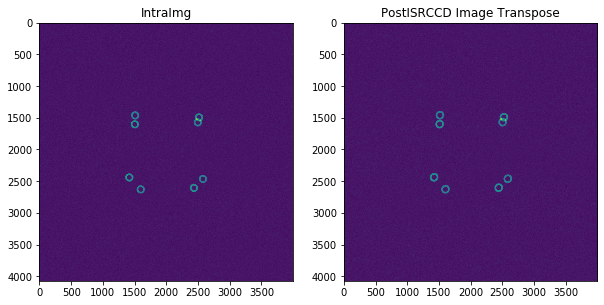

In [29]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1)
plt.imshow(intraImg)
plt.title('IntraImg')
fig.add_subplot(1,2,2)
plt.imshow(postIsrButlerExp.image.array.T)
plt.title('PostISRCCD Image Transpose')

Create the `starMap`, `neighborStarMap` from the database created by the `ts_wep` code from the input Phosim catalog.

In [14]:
bsc_database = '/astro/users/brycek/epyc/users/brycek/Commissioning/aos/ts_wep/tests/testData/bsc_skyfile_db.db3'
# Connect to database with SourceSelector
wep_cntl.sourSelc.connect(bsc_database)

In [15]:
# Set metadata for observation
ra = 0.
dec = 0.
rotPos = 0.
wep_cntl.sourSelc.setObsMetaData(ra, dec, rotPos)
neighborStarMap, starMap, wavefrontSensors = wep_cntl.sourSelc.getTargetStar()

/astro/users/brycek/epyc/projects/lsst_comm/stack_w_2020_15/stack/miniconda3-4.7.12-984c9f7/Linux64/sims_utils/2.13.0.sims-39-g2d90f6a+10/python/lsst/sims/utils/ModifiedJulianDate.py:197: UTCtoUT1Warning: UTC is outside of IERS table for UT1-UTC.
Returning UT1 = UTC for lack of a better idea
This warning was caused by calling ModifiedJulianDate.dut1

  category=UTCtoUT1Warning)


In [16]:
detector_starMap = starMap[detector_string]
detector_neighStarMap = neighborStarMap[detector_string]

In [17]:
detector_neighStarMap.getRaDecl()

{1: (359.737652, -0.266364),
 0: (359.737392, -0.258591),
 3: (359.793617, -0.264634),
 2: (359.792539, -0.260322),
 4: (359.789124, -0.203019),
 5: (359.797032, -0.210825),
 6: (359.732534, -0.212145),
 7: (359.742511, -0.2017)}

In [18]:
detector_neighStarMap.getRaDeclInPixel()

{1: (1462.9119725046478, 2490.210733843789),
 0: (1602.8122742516227, 2494.8807041895834),
 3: (1494.2315341129552, 1482.9315285766932),
 2: (1571.8361718943215, 1502.3287385735525),
 4: (2603.1561592941184, 1563.7324850203183),
 5: (2462.6902606523954, 1421.4124032264915),
 6: (2438.735307766243, 2582.262941295474),
 7: (2626.753736009448, 2402.6805929214543)}

In [19]:
detector_neighStarMap.starId

{0: [1], 1: [0], 2: [3], 3: [2], 4: [], 5: [], 6: [], 7: []}

What do the Science Images look like?

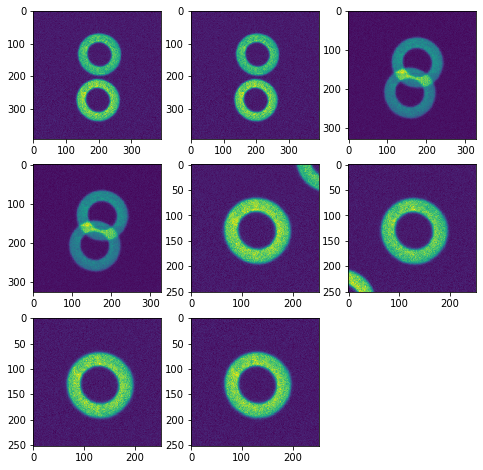

In [27]:
fig = plt.figure(figsize=(8,8))

# Configure the Source Processor with the detector we are looking at
wep_cntl.sourProc.config(abbrev_detector)

for i in range(len(detector_neighStarMap.starId)):
    singleSciNeiImg, allStarPosX, allStarPosY, magRatio, \
                                offsetX, offsetY = wep_cntl.sourProc.getSingleTargetImage(intraImg,
                                                                                          detector_neighStarMap,
                                                                                          i, FilterType.REF)
    fig.add_subplot(3,3,i+1)
    plt.imshow(singleSciNeiImg)

Look at the final donut images

In [21]:
donut_map = wep_cntl.getDonutMap(neighborStarMap, isrImgMap, FilterType.REF,
                                 doDeblending=True, postageImg=False, postageImgDir=None)

R:2,2 S:0,2 {17: (359.741092, 0.205379), 16: (359.733953, 0.208465), 19: (359.795179, 0.207644), 18: (359.790976, 0.2062), 20: (359.789073, 0.258627), 21: (359.797082, 0.266328), 22: (359.732467, 0.25732), 23: (359.742577, 0.267636)} {17: (1510.4243968706053, 2434.880492489059), 16: (1565.932272465897, 2563.381256214344), 19: (1551.4456897204268, 1461.4208375894866), 18: (1525.4369644614237, 1537.0617858694686), 20: (2468.998244301989, 1571.473766379045), 21: (2607.6386689920123, 1427.3514258328012), 22: (2445.2181215937026, 2590.2843921010517), 23: (2630.93313339232, 2408.3524340295817)}
R:2,2 S:0,1 {9: (359.738746, -0.024086), 8: (359.736299, -0.031469), 11: (359.795084, -0.028734), 10: (359.791072, -0.026822), 12: (359.788932, 0.024079), 13: (359.797223, 0.031476), 14: (359.730516, 0.029531), 15: (359.744528, 0.026025)} {9: (1600.9970281535075, 2472.889722902358), 8: (1468.1241028780462, 2516.9488444018907), 11: (1517.3864659271405, 1458.9310144544597), 10: (1551.7934661823338, 1531

In [22]:
donut_map

{'R:2,2 S:0,2': [<lsst.ts.wep.DonutImage.DonutImage at 0x7f221ffa2c90>,
 'R:2,2 S:0,1': [<lsst.ts.wep.DonutImage.DonutImage at 0x7f2207d7ca50>,
 'R:2,2 S:0,0': [<lsst.ts.wep.DonutImage.DonutImage at 0x7f22214cb850>,
  <lsst.ts.wep.DonutImage.DonutImage at 0x7f22214f9410>]}

In [23]:
detector_donut_map = donut_map[detector_string]

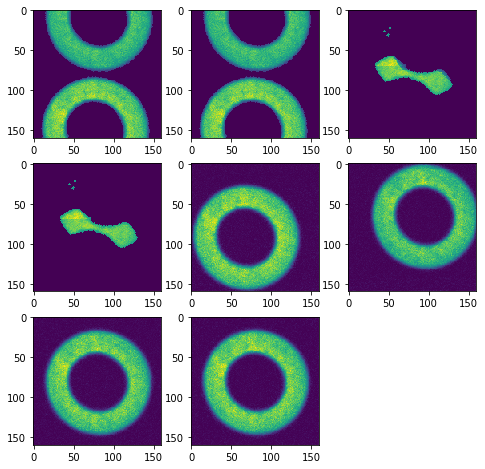

In [28]:
fig = plt.figure(figsize=(8,8))
for i in range(len(detector_donut_map)):
    fig.add_subplot(3, 3, i+1)
    plt.imshow(detector_donut_map[i].getIntraImg())